#### CAUTION

아래 커널은 반드시 `hyundai` 커널(오른쪽 상단 동그라미 옆을 확인하세요.)에서 진행해 주시길 바랍니다. <br>
해당 커널에서 아래 코드의 환경에 맞추어 Python Package들을 구성하였습니다.

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

# \[ 서버 실행하기 \]
---

Tensorflow Serving은 Docker 위에서 돌아가는 방식을 권장합니다.<br>

## 1. 모델 실행하기
---

아래의 코드를 Terminal 환경에서 동작시켜 주시길 바랍니다. <br>
아래의 코드는 Tensorflow Serving에 대한 Docker Container를 구성하여, 모델을 서빙하는 전과정을 실행합니다.<br>

----

````bash
# 1. hyundai virtual enviorment 환경 커널로 세팅하기
source activate hyundai 

# 2. 폴더 이동하기
cd ~/notebooks/RetinaMask-Instance-Segmentation

# 3. Docker 실행하기
python serving.py docker

````

---

## 2. [Optional] 시각화 색상 변경하기
----

`<label>_color`은 각 라벨 별 RGB 값을 지칭하는 지정자이고, `<class>_alpha`는 객체/영역에 대한 투명도 조절입니다. RGB값은 0~255 범위로 (R,G,B) 세 가지 모두 지정해주어야 하고, alpha 값은 0~1 범위로 커질수록, 라벨의 색상이 짙어집니다.

In [ ]:
from serving import save_hyundai_model_with_visualization

save_hyundai_model_with_visualization("../models/v0.0/",
                                      car_color=(255, 255, 0),
                                      bump_color=(160, 96, 0),
                                      manhole_color=(96, 0, 128),
                                      steel_color=(32, 96, 192),
                                      pothole_color=(96, 32, 128),
                                      other_road_color=(0, 0, 255),
                                      my_road_color=(0, 255, 0),
                                      crack_color=(255, 0, 0),
                                      instance_alpha=0.5,
                                      semantic_alpha=0.5)

Docker가 돌아가는 도중에 변경하더라도, Tensorflow-Serving에서 자동으로 변경된 모델로 바꿉니다.<br> 변경 사항이 반영되는 데 까지는 시간이 걸리므로, 변경 사항이 반영되기 전까지는 이전 모델로 계속 계산됩니다.

# \[ 서버와 통신하기 \]
---

Tensorflow Serving의 Input과 Output의 포맷을 바꾸었습니다. <br>
이전에는 숫자 행렬(numpy.array)을 전송하고 반환받았는데, 이는 데이터 전송량이 과도해져<br>
네트워크 속도에 지장을 주었습니다.<br>
이 문제를 해결하고자 JPG파일로 주고받는 방식으로 변경하였습니다. <br>

이로 인해, `bytes` 정보를 주고받는 식으로 변경되었습니다.

## 1. 단일 이미지 처리
---


### (1) 입력 데이터를 가져오기

입력데이터는 `jpg` 혹은 `png` 파일로 구성된 Bytes 정보를 가져오면 됩니다. 

In [2]:
# Test Image Content 가져오기
image_path = "../test/test_input.jpg"
with open(image_path, 'rb') as f:
    # jpg 파일을 bytes로 가져옴
    req_content = f.read()

해당 이미지는 아래의 방식으로 시각화할 수 있습니다.

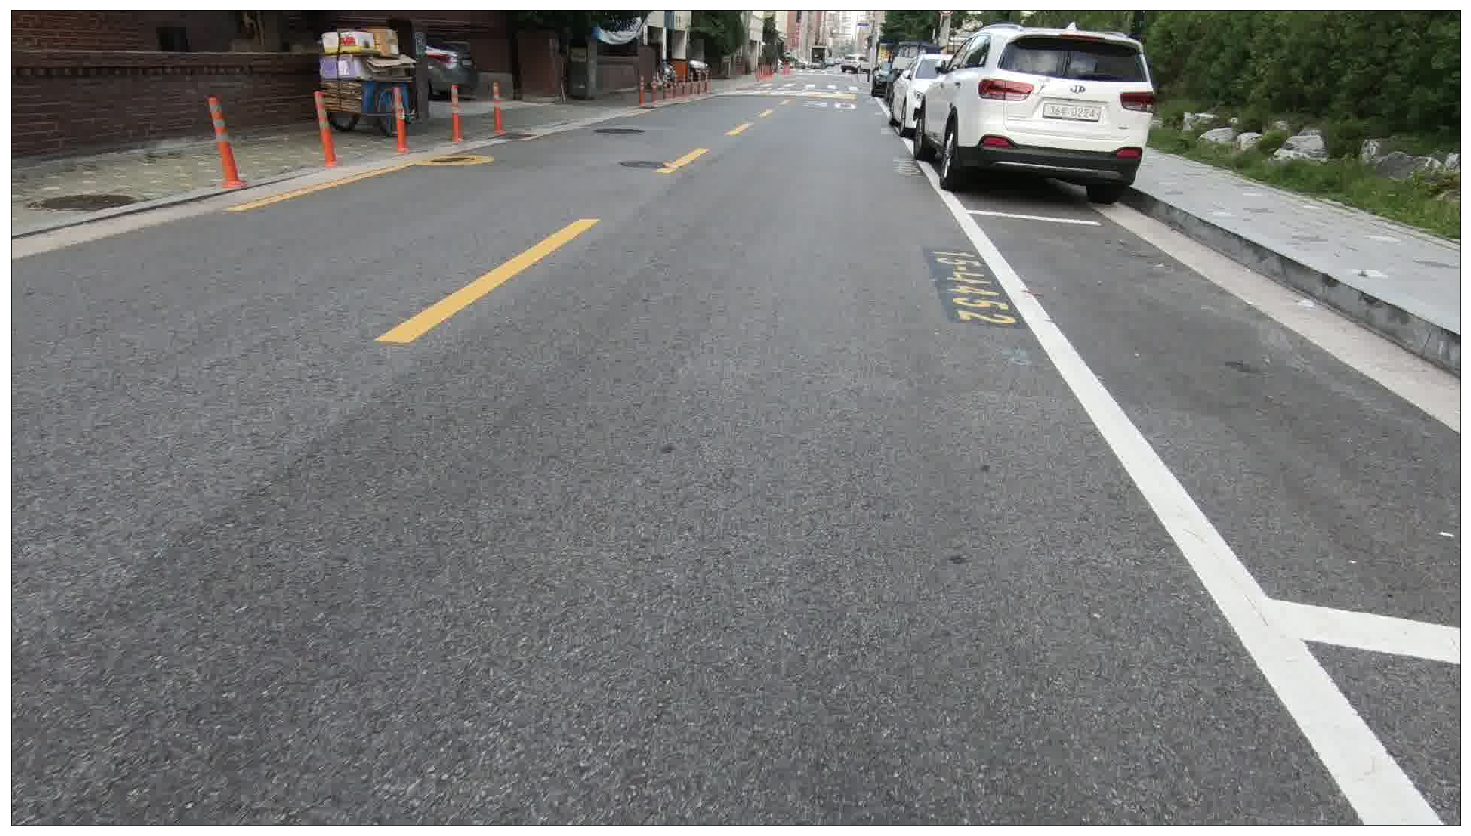

In [3]:
from serving import content_to_array
# File Content를 numpy array로 바꾸기
image = content_to_array(req_content) 
plt.figure(figsize=(30,15))
plt.imshow(image)
plt.xticks([]); plt.yticks([]);
plt.show()    

### (2) 서버에 파일을 전송하기

In [4]:
from serving import send_image_to_serving

# 서버에 jpg 파일을 전송하기 
vis_content, summary_content = send_image_to_serving(
    req_content, verbose=True)
# >>> result는 jpg binary 파일로 구성되어 있음

start to send message
Finished --- 8.672s



해당 이미지는 아래의 방식으로 시각화할 수 있습니다.

[{'class': 0,
  'cx': 1201,
  'cy': 112,
  'w': 88,
  'h': 114,
  'pixel_size': 4385,
  'estimated_size': 89,
  'include_my_road': 0},
 {'class': 0,
  'cx': 579,
  'cy': 76,
  'w': 73,
  'h': 83,
  'pixel_size': 4216,
  'estimated_size': 114,
  'include_my_road': 0},
 {'class': 1,
  'cx': 1038,
  'cy': 122,
  'w': 247,
  'h': 19,
  'pixel_size': 2500,
  'estimated_size': 37,
  'include_my_road': 1},
 {'class': 0,
  'cx': 1356,
  'cy': 137,
  'w': 310,
  'h': 237,
  'pixel_size': 56823,
  'estimated_size': 1138,
  'include_my_road': 0}]

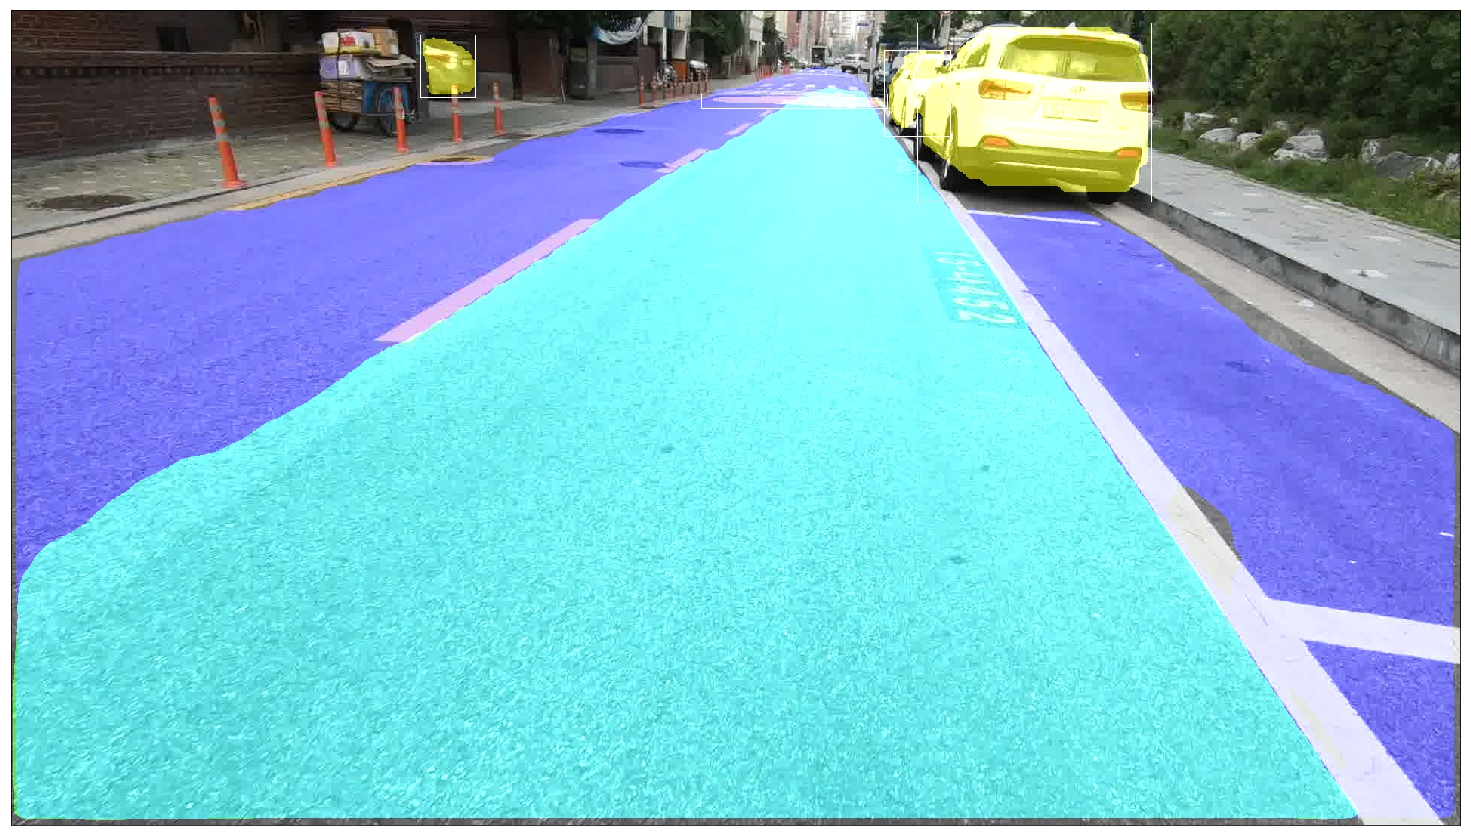

In [5]:
# File Content를 numpy array로 바꾸기
result_image = content_to_array(vis_content)
display(summary_content)
plt.figure(figsize = (30,15))
plt.imshow(result_image)
plt.xticks([]); plt.yticks([]);
plt.show()

## 2. 폴더 단위 처리
----

아래의 코드를 통해 폴더 단위로 실행시키면, input 디렉토리 내의 이미지들을 불러와 처리후, output 디렉토리에 넣습니다. 

----

````bash
# 1. hyundai virtual enviorment 환경 커널로 세팅하기
source activate hyundai 

# 2. 폴더 이동하기
cd ~/notebooks/RetinaMask-Instance-Segmentation

# 3. Docker 실행하기
python serving.py folder <input directory> <output directory>

````

---

In [ ]:
from serving import process_folder

input_path = '/data/home/brframe/roadview-test/test/Inputs'
output_path = '/data/home/brframe/roadview-test/test/Outputs'
process_folder(input_path, output_path,verbose=True)

In [ ]:
from PIL import Image
sample_img = Image.open(os.path.join(output_path, 'K3_00038.jpg'))
plt.figure(figsize = (30,15))
plt.xticks([]); plt.yticks([]);
plt.imshow(sample_img)